# Análise comparativa de modelos

In [134]:
# import libraries

from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.classifier import ConfusionMatrix
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

import shap
shap.initjs()

## 1. Obtenção de dados

In [215]:
df = pd.read_csv("../data/raw/Churn_Modelling.csv")
dictionary = pd.read_csv("../data/external/dictionary.csv")
df, dictionary

(      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
 0             1    15634602   Hargrave          619    France  Female   42   
 1             2    15647311       Hill          608     Spain  Female   41   
 2             3    15619304       Onio          502    France  Female   42   
 3             4    15701354       Boni          699    France  Female   39   
 4             5    15737888   Mitchell          850     Spain  Female   43   
 ...         ...         ...        ...          ...       ...     ...  ...   
 9995       9996    15606229   Obijiaku          771    France    Male   39   
 9996       9997    15569892  Johnstone          516    France    Male   35   
 9997       9998    15584532        Liu          709    France  Female   36   
 9998       9999    15682355  Sabbatini          772   Germany    Male   42   
 9999      10000    15628319     Walker          792    France  Female   28   
 
       Tenure    Balance  NumOfProducts  HasCrCard

## 2. Preparação de dados

In [216]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dictionary = dictionary.drop(index=0)
df.isnull().sum().sum()
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [217]:
target_column = 'Exited'

rest_columns = (
    dictionary
    .query("variavel != ['Geography', 'Gender', @target_column]")
    .variavel
    .to_list()
)
rest_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

Intervalo interquartil (`IQR`) para identificar e remover outliers, entre Q3 e Q1, com fator adaptado para 1.4

In [218]:
q1 = df[rest_columns].quantile(0.25)
q3 = df[rest_columns].quantile(0.75)
iqr = q3 - q1

factor = 1.4

lower_bound = q1 - factor * iqr
upper_bound = q3 + factor * iqr

df = df[~((df <= lower_bound) | (df >= upper_bound)).any(axis=1)]
upper_bound, lower_bound


/tmp/ipykernel_42324/1691549094.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df <= lower_bound) | (df >= upper_bound)).any(axis=1)]


(CreditScore           905.600
 Age                    60.800
 Tenure                 12.600
 Balance            306346.176
 NumOfProducts           3.400
 HasCrCard               2.400
 IsActiveMember          2.400
 EstimatedSalary    287128.840
 dtype: float64,
 CreditScore           396.4000
 Age                    15.2000
 Tenure                 -2.6000
 Balance           -178701.9360
 NumOfProducts          -0.4000
 HasCrCard              -1.4000
 IsActiveMember         -1.4000
 EstimatedSalary    -86738.4825
 dtype: float64)

In [219]:
df = pd.get_dummies(df, drop_first=True)
nominal_columns = [col for col in df.columns if (col.startswith('Geography_') or col.startswith('Gender_')) and col != target_column]

In [220]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [221]:
X = df.drop(columns=[target_column], axis=1)
y = df[target_column]

539 outliers removidos

In [222]:
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1


A classe `Exited` está desbalanceada com 7614 no 0 e 1847 no 1

In [223]:
np.unique(y, return_counts=True)

(array([0, 1]), array([7614, 1847]))

`SMOTE` utiliza a distância euclidiana entre os 5 vizinhos mais próximos (valor padrão de KNN) da classe minoritária

In [224]:
smote = SMOTE(sampling_strategy='minority')

In [225]:
X_res, y_res = smote.fit_resample(X,y)

In [226]:
np.unique(y_res,return_counts=True), y_res.value_counts()

((array([0, 1]), array([7614, 7614])),
 1    7614
 0    7614
 Name: Exited, dtype: int64)

5767 dados enriquecidos para a classe minoritária

In [227]:
pd.DataFrame(X_res)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.000000,1,1,1,101348.880000,0,0,0
1,608,41,1,83807.860000,1,0,1,112542.580000,0,1,0
2,502,42,8,159660.800000,3,1,0,113931.570000,0,0,0
3,699,39,1,0.000000,2,0,0,93826.630000,0,0,0
4,850,43,2,125510.820000,1,1,1,79084.100000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15223,663,42,7,0.000000,1,1,0,68636.751229,0,0,0
15224,508,33,7,116895.572759,1,0,1,115365.353889,1,0,0
15225,780,45,5,0.000000,1,1,0,187984.785626,0,0,0
15226,616,49,4,110294.545779,1,0,0,177638.249429,1,0,0


In [ ]:
# Verificando os outliers nas features numéricas
num_cols = len(rest_columns)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))

for i, col in enumerate(rest_columns):
    sns.boxplot(y=X_res[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  

plt.tight_layout()

plt.show()

In [228]:
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    #('encoding', OneHotEncoder(sparse_output=False)), 
    ('normalization', StandardScaler()) 
])
rest_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), 
    ('normalization', StandardScaler()) 
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('rest', rest_preprocessor, rest_columns)
])

In [232]:
X_res

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.000000,1,1,1,101348.880000,0,0,0
1,608,41,1,83807.860000,1,0,1,112542.580000,0,1,0
2,502,42,8,159660.800000,3,1,0,113931.570000,0,0,0
3,699,39,1,0.000000,2,0,0,93826.630000,0,0,0
4,850,43,2,125510.820000,1,1,1,79084.100000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15223,663,42,7,0.000000,1,1,0,68636.751229,0,0,0
15224,508,33,7,116895.572759,1,0,1,115365.353889,1,0,0
15225,780,45,5,0.000000,1,1,0,187984.785626,0,0,0
15226,616,49,4,110294.545779,1,0,0,177638.249429,1,0,0


In [194]:
X_res = preprocessor.fit_transform(X_res)
pd.DataFrame(X_res)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.569767,-0.460996,-0.842645,-0.342869,0.286101,-1.048923,-1.319787,-0.732563,0.774977,1.347913,0.014974
1,-0.569767,2.169218,-0.842645,-0.464769,0.167515,-1.416668,0.040380,-0.732563,-1.290362,1.347913,0.208722
2,-0.569767,-0.460996,-0.842645,-1.639443,0.286101,1.157547,1.271443,3.036175,0.774977,-0.741888,0.232763
3,-0.569767,-0.460996,-0.842645,0.543678,-0.069658,-1.416668,-1.319787,1.151806,-1.290362,-0.741888,-0.115225
4,-0.569767,2.169218,-0.842645,2.217035,0.404688,-1.048923,0.717203,-0.732563,0.774977,1.347913,-0.370398
...,...,...,...,...,...,...,...,...,...,...,...
15223,-0.569767,-0.460996,-0.842645,-1.462134,-0.899764,-1.048923,-1.319787,-0.732563,0.774977,1.347913,1.318442
15224,1.755103,-0.460996,1.186739,-0.309623,1.471966,-1.416668,0.821191,-0.732563,-1.290362,-0.741888,-1.687748
15225,-0.569767,-0.460996,-0.842645,-0.509096,1.827725,0.422057,-1.319787,-0.732563,0.774977,-0.741888,-1.403570
15226,-0.569767,-0.460996,1.186739,0.155814,0.641861,-1.784413,0.621150,-0.732563,-1.290362,-0.741888,-0.394185


## 3. Seleção de modelos

In [230]:
n_splits_comparative_analysis = 10
n_folds_grid_search = 5
test_size = .25
random_state = 42
scoring = 'accuracy'
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

max_iter = 100
models = [
    ('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=random_state), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 7]
    }),
    
    ('Multi-layer Perceptron classifier', MLPClassifier(random_state=random_state), {
        'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,), (12, 12)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive']
    }),
]

In [233]:
results = pd.DataFrame({})
cross_validate_grid_search = KFold(n_splits=n_folds_grid_search)
cross_validate_comparative_analysis = ShuffleSplit(n_splits=n_splits_comparative_analysis, test_size=test_size, random_state=random_state)
for model_name, model_object, model_parameters in models:
    print(f"running {model_name}...")
    model_grid_search = GridSearchCV(
        estimator=model_object,
        param_grid=model_parameters,
        scoring=scoring,
        n_jobs=-1,
        cv=cross_validate_grid_search
    )
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_grid_search)
    ])
    scores = cross_validate(
        estimator=approach,
        X=X_res,
        y=y_res,
        cv=cross_validate_comparative_analysis,
        n_jobs=-1,
        scoring=metrics
    )
    scores['model_name'] = [model_name] * n_splits_comparative_analysis
    display(pd.DataFrame(scores).agg(['mean', 'std']))
    results = pd.concat([results, pd.DataFrame(scores)], ignore_index=True)

running Gradient Boosting Classifier...


/tmp/ipykernel_42324/1481056750.py:26: FutureWarning: ['model_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(pd.DataFrame(scores).agg(['mean', 'std']))


,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
mean,1218.202433,0.108785,0.864408,0.864490,0.864464,0.864373
std,285.722304,0.062086,0.005294,0.005399,0.005252,0.005305


running Multi-layer Perceptron classifier...


/home/balda/equipe1-2024.1/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/balda/equipe1-2024.1/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/balda/equipe1-2024.1/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/balda/equipe1-2024.1/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


KeyboardInterrupt: 

### 3.* Testando manualmente

In [196]:
X_res.shape, y_res.shape

((15228, 11), (15228,))

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size=0.25, 
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11421, 11), (11421,), (3807, 11), (3807,))

In [212]:
def grid_search_cv(estimator, param_grid, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=None):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid_search.fit(x_train, y_train)
    return grid_search.best_params_, grid_search

In [198]:
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (12,12)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [206]:
gb = GradientBoostingClassifier(random_state=42)
gb_best_params = grid_search_cv(gb, gb_param_grid, X_train, y_train)
print("Melhores parâmetros para GradientBoostingClassifier:", gb_best_params)

Best parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [199]:
model_gradient = GradientBoostingClassifier(learning_rate= 0.1, 
                                            max_depth= 7, 
                                            n_estimators= 300,
                                            random_state=42)

In [200]:
model_gradient.fit(X_train, y_train)
y_pred = model_gradient.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1973
           1       0.84      0.87      0.86      1834

    accuracy                           0.86      3807
   macro avg       0.86      0.86      0.86      3807
weighted avg       0.86      0.86      0.86      3807



0.8602574205411084

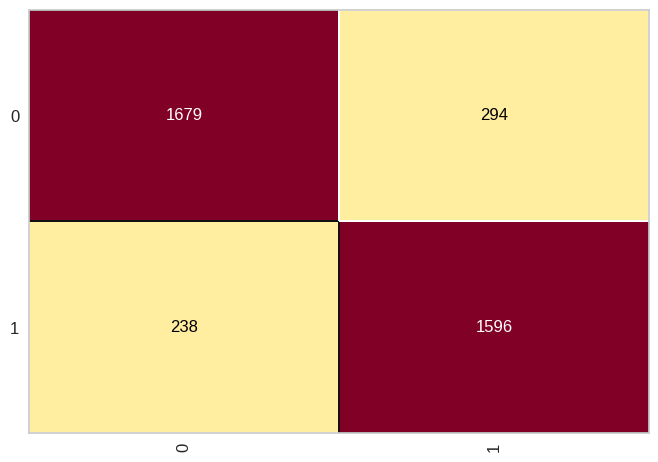

In [201]:
cm = ConfusionMatrix(model_gradient)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

<Axes: >

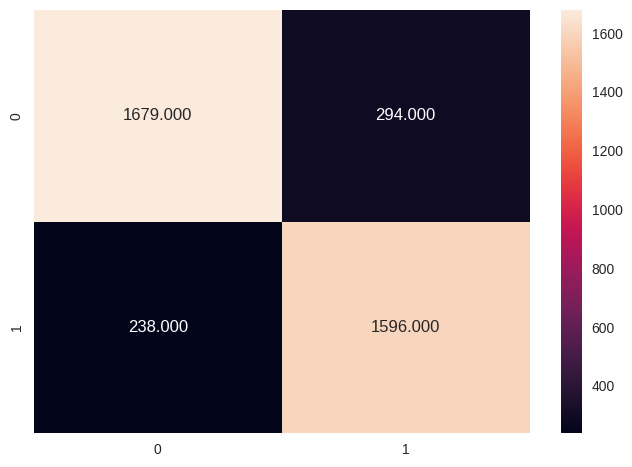

In [202]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="0.3f")

In [ ]:
mlp = MLPClassifier(random_state=42)
mlp_best_params = grid_search_cv(mlp, mlp_param_grid, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1)

In [110]:
print("Melhores parâmetros para MLPClassifier:", mlp_best_params)

Melhores parâmetros para MLPClassifier: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [111]:
model_mlp = MLPClassifier(max_iter=100, 
                            verbose=True, 
                            alpha=0.05,
                            learning_rate='constant',
                            tol=0.0000100, 
                            solver='adam', 
                            activation='relu', 
                            hidden_layer_sizes=(100,))
model_mlp.fit(X_train, y_train)

Iteration 1, loss = 0.55600957
Iteration 2, loss = 0.45317896
Iteration 3, loss = 0.43515428
Iteration 4, loss = 0.42733785
Iteration 5, loss = 0.42046855
Iteration 6, loss = 0.41453786
Iteration 7, loss = 0.40844435
Iteration 8, loss = 0.40346835
Iteration 9, loss = 0.39980432
Iteration 10, loss = 0.39584233
Iteration 11, loss = 0.39376280
Iteration 12, loss = 0.39120664
Iteration 13, loss = 0.38908310
Iteration 14, loss = 0.38759944
Iteration 15, loss = 0.38625384
Iteration 16, loss = 0.38523833
Iteration 17, loss = 0.38379270
Iteration 18, loss = 0.38383503
Iteration 19, loss = 0.38271973
Iteration 20, loss = 0.38215867
Iteration 21, loss = 0.38091677
Iteration 22, loss = 0.38063416
Iteration 23, loss = 0.38016450
Iteration 24, loss = 0.38005458
Iteration 25, loss = 0.37926741
Iteration 26, loss = 0.37927196
Iteration 27, loss = 0.37840221
Iteration 28, loss = 0.37851203
Iteration 29, loss = 0.37786024
Iteration 30, loss = 0.37783742
Iteration 31, loss = 0.37738746
Iteration 32, los

/home/balda/equipe1-2024.1/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.05, max_iter=100, tol=1e-05, verbose=True)

In [208]:
y_pred = model_mlp.predict(X_test)

In [209]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1973
           1       0.82      0.82      0.82      1834

    accuracy                           0.83      3807
   macro avg       0.83      0.83      0.83      3807
weighted avg       0.83      0.83      0.83      3807



0.8284738639348569

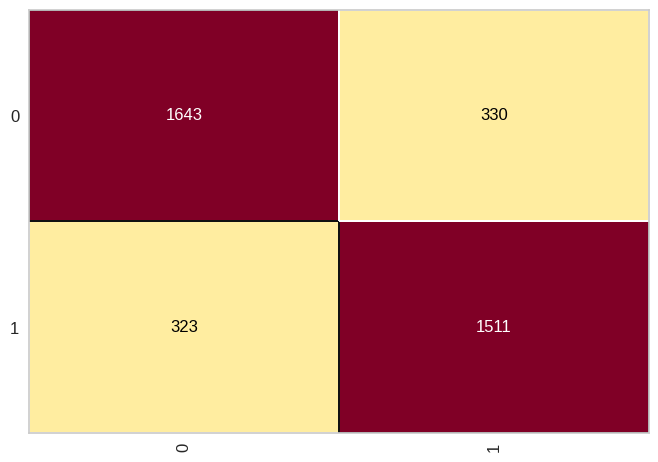

In [211]:
cm = ConfusionMatrix(model_mlp)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

### 3.* Explicabilidade com `shap`

In [119]:
explainer = shap.KernelExplainer(model_gradient.predict, shap.kmeans(X_train, 10))

In [120]:
shap_values = explainer.shap_values(X_test)

100%|██████████| 3807/3807 [20:55<00:00,  3.03it/s]


In [127]:
feature_names = X.columns.tolist()
feature_names


['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male']

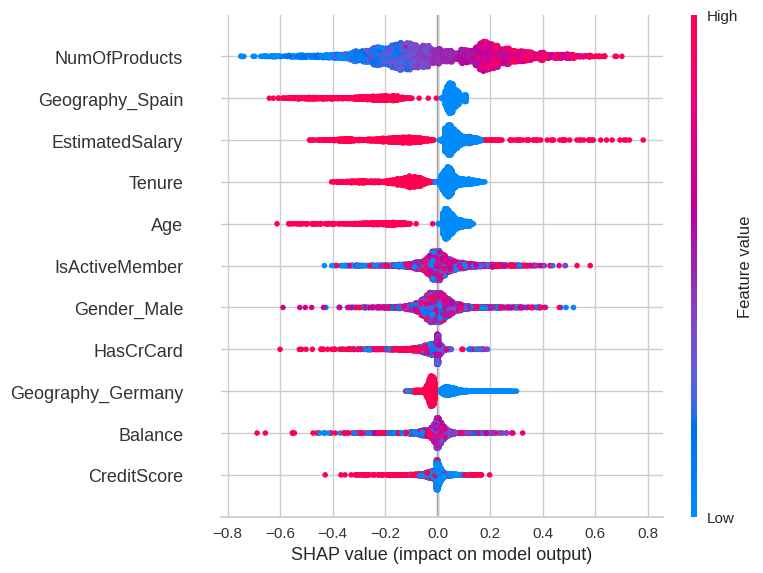

In [133]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [129]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=feature_names)

### 3.2 Persistência do modelo

In [237]:
joblib.dump(model_gradient, '../models/model_gb.joblib') 

['../models/model_gb.joblib']